In [1]:
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
from PIL import Image

In [2]:
from tqdm import tqdm

In [3]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)

In [4]:
if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

In [5]:
transform = transforms.Compose([transforms.Resize((100, 100)),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.Flowers102(root="StanfordCars/", 
                    split='train', 
                    transform=transform,
                    download=True)
test_dataset = torchvision.datasets.Flowers102(root="StanfordCars/", 
                    split='test',
                    transform=transform,
                    download=True)

In [6]:
batch_size = 64

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

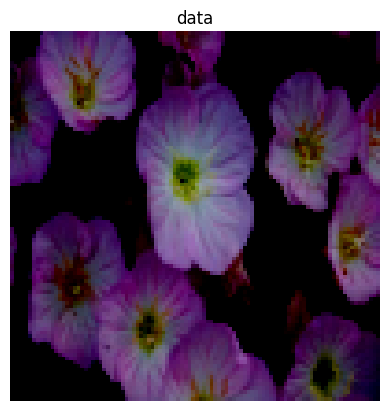

In [7]:
import matplotlib.pyplot as plt

sample = train_dataset[0][0].numpy()
sample = np.transpose(sample,(1,2,0))

fig, ax = plt.subplots(1,1)
ax.set_title('data')
ax.set_axis_off()
ax.imshow(sample)
plt.show()

In [8]:
##### AutoEncoder 모델 코드 #####

class Encoder(nn.Module):
  def __init__(self,):
    super(Encoder, self).__init__()
    self.encode = nn.Sequential(nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
                                nn.ReLU(), nn.BatchNorm2d(16),
                                nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
                                nn.ReLU(), nn.BatchNorm2d(32))
  def forward(self, input):
    return self.encode(input)

class Decoder(nn.Module):
  def __init__(self, ):
    super(Decoder, self).__init__()
    self.decode = nn.Sequential(nn.Conv2d(32, 16, kernel_size=2, stride=1, padding=13),
                                nn.ReLU(), nn.BatchNorm2d(16),
                                nn.Conv2d(16, 8, kernel_size=2, stride=1, padding=13),
                                nn.ReLU(), nn.BatchNorm2d(8),
                                nn.Conv2d(8, 3, kernel_size=2, stride=1, padding=13),
                                nn.ReLU(), nn.BatchNorm2d(3))
  def forward(self, input):
    return self.decode(input)

class AutoEncoder(nn.Module):
  def __init__(self):
    super(AutoEncoder, self).__init__()
    self.encoder = Encoder()
    self.decoder = Decoder()

  def forward(self, input):
    z = self.encoder(input)
    x_hat = self.decoder(z)
    return z, x_hat

In [9]:
##### AutoEncoder 학습 코드 #####

AE_model = AutoEncoder().to(device)
AE_optimizer = optim.Adam(AE_model.parameters(), lr=0.001)
AE_criterion = nn.MSELoss()

AE_model.train()
epochs = 30

for epoch in range(epochs):
  AE_model.train()
  avg_cost = 0
  total_batch_num = len(train_loader)

  for b_x, b_y in train_loader:
    b_x = b_x.to(device)
    b_y = b_y.to(device)

    z, b_x_hat = AE_model(b_x)
    AE_loss = AE_criterion(b_x_hat, b_x)

    avg_cost += AE_loss/total_batch_num
    AE_optimizer.zero_grad()
    AE_loss.backward()
    AE_optimizer.step()
  
  print('Epoch: {}/{}\t Cost: {:04f}'.format(epoch+1, epochs, avg_cost))

Epoch: 1/30	 Cost: 1.224686
Epoch: 2/30	 Cost: 1.149044
Epoch: 3/30	 Cost: 1.103871
Epoch: 4/30	 Cost: 1.065303
Epoch: 5/30	 Cost: 1.029874
Epoch: 6/30	 Cost: 0.995550
Epoch: 7/30	 Cost: 0.964321
Epoch: 8/30	 Cost: 0.932917
Epoch: 9/30	 Cost: 0.902536
Epoch: 10/30	 Cost: 0.874551
Epoch: 11/30	 Cost: 0.848420
Epoch: 12/30	 Cost: 0.823801
Epoch: 13/30	 Cost: 0.799003
Epoch: 14/30	 Cost: 0.775812
Epoch: 15/30	 Cost: 0.754119
Epoch: 16/30	 Cost: 0.733225
Epoch: 17/30	 Cost: 0.713288
Epoch: 18/30	 Cost: 0.693842
Epoch: 19/30	 Cost: 0.674943
Epoch: 20/30	 Cost: 0.657089
Epoch: 21/30	 Cost: 0.640108
Epoch: 22/30	 Cost: 0.622920
Epoch: 23/30	 Cost: 0.606691
Epoch: 24/30	 Cost: 0.588993
Epoch: 25/30	 Cost: 0.530418
Epoch: 26/30	 Cost: 0.509349
Epoch: 27/30	 Cost: 0.495834
Epoch: 28/30	 Cost: 0.484120
Epoch: 29/30	 Cost: 0.473130
Epoch: 30/30	 Cost: 0.463094


In [10]:
##### Classifier 모델 코드 #####

class Classifier(nn.Module):
  def __init__(self):
    super(Classifier, self).__init__()
    self.classify = nn.Sequential(nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
                                  nn.BatchNorm2d(64), nn.ReLU(),
                                  nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
                                  nn.BatchNorm2d(128), nn.ReLU(), nn.Flatten(),
                                  nn.Linear(128*7*7, 256), nn.ReLU(),
                                  nn.Linear(256, 102))
  def forward(self, input):
    return self.classify(input)

In [11]:
##### Classifier 학습 코드 #####

classifier = Classifier().to(device)
optimizer = optim.Adam([{'params':AE_model.parameters(), 'lr':0.001},
                        {'params':classifier.parameters(), 'lr':0.001}])
criterion = nn.CrossEntropyLoss()

AE_model.train()
classifier.train()
total_batch_num = len(train_loader)
epochs = 30

for epoch in range(epochs):
  avg_cost = 0
  
  for b_x, b_y in train_loader:
    b_x = b_x.to(device)
    b_y = b_y.to(device)

    z, b_x_hat = AE_model(b_x)
    logits = classifier(z)
    loss = criterion(logits, b_y)

    avg_cost += loss/total_batch_num
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  
  print('Epoch: {}/{}\t Cost: {:04f}'.format(epoch+1, epochs, avg_cost))

Epoch: 1/30	 Cost: 4.579401
Epoch: 2/30	 Cost: 3.681389
Epoch: 3/30	 Cost: 2.816148
Epoch: 4/30	 Cost: 1.987860
Epoch: 5/30	 Cost: 1.200297
Epoch: 6/30	 Cost: 0.602762
Epoch: 7/30	 Cost: 0.262633
Epoch: 8/30	 Cost: 0.106519
Epoch: 9/30	 Cost: 0.053892
Epoch: 10/30	 Cost: 0.029365
Epoch: 11/30	 Cost: 0.019942
Epoch: 12/30	 Cost: 0.015449
Epoch: 13/30	 Cost: 0.012002
Epoch: 14/30	 Cost: 0.010194
Epoch: 15/30	 Cost: 0.008885
Epoch: 16/30	 Cost: 0.007571
Epoch: 17/30	 Cost: 0.006624
Epoch: 18/30	 Cost: 0.005909
Epoch: 19/30	 Cost: 0.005833
Epoch: 20/30	 Cost: 0.004890
Epoch: 21/30	 Cost: 0.004696
Epoch: 22/30	 Cost: 0.004191
Epoch: 23/30	 Cost: 0.003920
Epoch: 24/30	 Cost: 0.003679
Epoch: 25/30	 Cost: 0.003323
Epoch: 26/30	 Cost: 0.003178
Epoch: 27/30	 Cost: 0.002810
Epoch: 28/30	 Cost: 0.002696
Epoch: 29/30	 Cost: 0.002441
Epoch: 30/30	 Cost: 0.002278


In [12]:
##### Classifier 정확도 측정 코드 #####

correct = 0
total = 0

AE_model.eval()
classifier.eval()

for b_x, b_y in test_loader:
  b_x = b_x.to(device)
  b_y = b_y.to(device)
  with torch.no_grad():
    z, b_x_hat = AE_model(b_x)
    logits = classifier(z)

  predicts = torch.argmax(logits, dim=1)

  total += len(b_y)
  correct += (predicts == b_y.to(device)).sum().item()

accuracy = 100*correct/total
  
print('Accuracy: {:.2f} %'.format(accuracy))

Accuracy: 23.45 %


In [13]:
print(len(train_dataset))
print(len(test_dataset))

1020
6149
